# **Data Pre-processing**
> In this notebook, I'll inculde all the features in training the model.  

> The data will be pre-processed to see if the confusion matrix indicates better model performance

## Load the data

In [ ]:
import pandas as pd
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/snow_objects.csv

dataset = pd.read_csv('snow_objects.csv', delimiter='\t')

In [ ]:
# dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   size       2200 non-null   float64
 1   roughness  2200 non-null   float64
 2   color      2200 non-null   object 
 3   motion     2200 non-null   float64
 4   label      2200 non-null   object 
dtypes: float64(3), object(2)
memory usage: 86.1+ KB


In [ ]:
# the color column is a categorical, hence:
dataset['color'] = dataset['color'].astype('category')

In [ ]:
# divide dataset into features and target

# features
X = dataset[['size', 'roughness', 'color', 'motion']].copy()

# target
y = dataset['label']

# the indices of the numeric and categorical features in the dataframe:
numerical_features = [0, 1, 3]
categorical_features = [2]

In [ ]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42)

## Preprocessing
> To preprocess the features, a [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) will be used to wrap _transformers_ in form of [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)

In [ ]:
# import
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
# scale numeric features
num_transformer = Pipeline(steps=[
    # (name of step, transform)
    ('impute', SimpleImputer(strategy='median')), #handle missing values
    ('scale', StandardScaler()) # scale
])

# encode categorical features
cat_transformer = Pipeline(steps=[
    # (name of step, transform)
    ('impute', SimpleImputer(strategy='most_frequent')), # handle missing values
    ('encode', OneHotEncoder(handle_unknown='ignore')) # encode
])

# wrap both transformers in a ColumnTransformer object
preprocessor = ColumnTransformer(transformers=[
    # (name, transformer, columns)
    ('num', num_transformer, numerical_features), # numerical
    ('cat', cat_transformer, categorical_features) # categorical
])

## Building a classification model
> Since we'd already done exloratory data analysis in the previous notebook, we'll jump right into building a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict the class that an object belongs to

In [ ]:
%%time
# import RandomForestClassfier
from sklearn.ensemble import RandomForestClassifier

# pipeline with preprocessor and default estimator parameters
forest_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor), # preprocess
    ('rfc', RandomForestClassifier(n_estimators=100, random_state=42)) # estimator
])

# train the model
forest_pipeline.fit(X_train, y_train)
print('')


CPU times: user 304 ms, sys: 12.6 ms, total: 317 ms
Wall time: 436 ms


## Let's build a confusion matrix
> Time to build a [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#confusion-matrix) like such:
+ `sklearn.metrics.confusion_matrix(y_true, y_pred)`

In [ ]:
from sklearn.metrics import confusion_matrix

# get predictions
y_pred = forest_pipeline.predict(X_test)

# get and print the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[ 39  24   1   0]
 [ 13 106   4   0]
 [  0   0 222   0]
 [  1   1   0 249]]


#### Visualizing the `confusion_matrix` using [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

> The `confusion_matrix` would be more perceptive if visually presented  

> Luckily, the [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) class has a _classmethod_ [`from_predictions()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) that can plot the confusion matrix given the `y_true` and `y_pred` labels

In [ ]:
# import
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

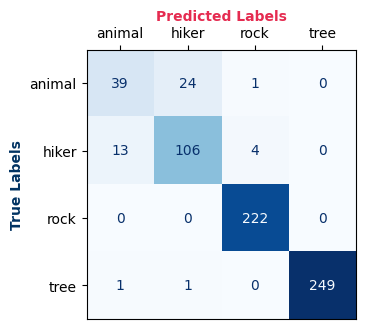

In [ ]:
# specify subplot and figure
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        cmap='Blues',
                                        colorbar=False,
                                        ax = ax)

# modify label appearance
ax.set_xlabel('Predicted Labels', weight='black', color='#E52B50')
ax.set_ylabel('True Labels', weight='black', color='#003262')

# move the xaxis ticks and label to top of plot
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.show()

In [ ]:
# distribution of actual labels in test_set:
y_test.value_counts()

label
tree      251
rock      222
hiker     123
animal     64
Name: count, dtype: int64

# **Evaluation**
> A `confusion_matrix` displays the number of `TP`, `TN` `FP` & `FN` from which other evaluations metrics can be derived.
+ `TP` - True Positives: a positive label is correctly predicted
+ `TN` - True Negatives: a negative label is correctly predicted
+ `FP` - False Positives: a negative label is predicted as a positive
+ `FN` - False Negatives: a positive label is predicted as a negative


### Evaluation Metrics
> From the numbers listed above, the following evaluation metrics can be derived

#### **Accuracy**
> Accuracy is the number of correct predictions (both `TP` & `TN`) divided by the total number of predictions:

```
    accuracy = (TP+TN) / number of samples
```

#### **Recall / sensitivity / True Positive Rate**
> The measure of the proportion of `TP` out of the actual positives
+ Out of _all_ the instances of a particular class in a dataset, how many did the model correctly identify?

```
    recall = sensitivity = TP / (TP + FN)
```

#### **Precision**
> The measure of proportion of `TP` out of the predicted positives
+ Out of all positive predictions made for a particular class, how many were _truly positive_ labels?  

```
    precision = TP / (TP + FP)
```

#### **F1 score**
> The harmonic mean of `recall` and `precision`

```
    2 * [ (precision*recall) / (precision+recall) ]
```

#### **Specificity / True Negative Rate**
> Expresses the fraction of `TN` predicted over the total number of existing negative samples
+ Proportion of `TN` (actual negatives) that were correcly identified over the total number of existing negative samples

```
    specificity = TN / (FP + TN)
```

#### **False Positive Rate / False Alarm Rate**
> The number of `FP` predictions divided by the total number of negative samples:
+ Out of all the actual negatives, how many were misclassified as positives?

```
    fpr = FP / (FP + TN)
```

#### **Support**
> Number of actual occurrrences of each class in the true labels of the dataset

> 📝 **Note**  
> For what it's worth:
+ `FPR + spacificity = 1`
+ `sensitivity` and `spacificity` are inversely proportional
+ `TPR` and `FPR` are directly proportional

### [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [ ]:
# accuracy score
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(acc, 2)}')

Accuracy: 0.93


### [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
> Returns a summary of the `precision`, `recall`, `F1` score for each class, as well as averages  

> **Method call**
```
classification_report(y_true, y_pred, *, labels=None, target_names=None,
sample_weight=None, digits=2, output_dict=False, zero_division='warn')
```

In [ ]:
# metrics using sklearn
from sklearn.metrics import classification_report

cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

      animal       0.74      0.61      0.67        64
       hiker       0.81      0.86      0.83       123
        rock       0.98      1.00      0.99       222
        tree       1.00      0.99      1.00       251

    accuracy                           0.93       660
   macro avg       0.88      0.87      0.87       660
weighted avg       0.93      0.93      0.93       660



### [`imblearn.metrics.classification_report_imbalanced()`](https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.classification_report_imbalanced.html)
> Returns summary of the `precision`, `recall`, `specificity`, `geometric mean`, and `index balanced accuracy`  

> **Method call**
```
classification_report_imbalanced(y_true, y_pred, *, labels=None,
target_names=None, sample_weight=None, digits=2, alpha=0.1, output_dict=False,
zero_division='warn')
```

In [ ]:
# metrics using imblearn
from imblearn.metrics import classification_report_imbalanced

cri = classification_report_imbalanced(y_test, y_pred)
print(cri)

                   pre       rec       spe        f1       geo       iba       sup

     animal       0.74      0.61      0.98      0.67      0.77      0.57        64
      hiker       0.81      0.86      0.95      0.83      0.91      0.81       123
       rock       0.98      1.00      0.99      0.99      0.99      0.99       222
       tree       1.00      0.99      1.00      1.00      1.00      0.99       251

avg / total       0.93      0.93      0.99      0.93      0.96      0.92       660



# **Conclusion**
> In this notebook, I've implemented the following:
> + Included the `color` column in the training set, to give a true representation of the dataset  
> + Pre-processed the features (scaling numerical features & encoding categorical columns)
> + Increased the `n_iterators` of the `RandomForestClassifier` from `1` to `100`

> Despite all that, the `confusion_matrix` illustrates the model still performs dismally on `animal` and `hiker` classes 💔



> 💡 **Insight**  
> + The model performs poorly on the `animal` and `hiker` classes, since they are poorly represented in the dataset

> ▶️ **Up Next**  
+ We'll be _resampling_ the training data so that the model has enough to train on all label classes, and see how that goes.